In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, f1_score

In [199]:
# Check if there any GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU available') # avaiable count GPU
    print (f'Using "{torch.cuda.get_device_name(0)}" as the GPU', ) # name using GPU  
else:
    print ('No gpu avaiable')
    device = torch.device('cpu')

There are 1 GPU available
Using "NVIDIA GeForce RTX 3060 Ti" as the GPU


### EDA

In [200]:
df = pd.read_csv("Customer-Churn-Records.csv")
df.tail()

# no null/nan

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0,0,3,DIAMOND,911


In [201]:
df = df.drop(['RowNumber', 'CustomerId', 'Geography', 'Surname', 'IsActiveMember'], axis=1)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Gender              10000 non-null  object 
 2   Age                 10000 non-null  int64  
 3   Tenure              10000 non-null  int64  
 4   Balance             10000 non-null  float64
 5   NumOfProducts       10000 non-null  int64  
 6   HasCrCard           10000 non-null  int64  
 7   EstimatedSalary     10000 non-null  float64
 8   Exited              10000 non-null  int64  
 9   Complain            10000 non-null  int64  
 10  Satisfaction Score  10000 non-null  int64  
 11  Card Type           10000 non-null  object 
 12  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 1015.8+ KB


In [203]:
df_cardType = pd.unique(df['Card Type'])
satisfy = df['Satisfaction Score'].unique()
tenor = df['Tenure'].max()
credits = df

max_bal = df['Balance'].max()
min_bal = df['Balance'].min()

ls = [df_cardType, max_bal, min_bal, satisfy, tenor]

for i in ls:
    print(i, "|", end=" ")

['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM'] | 250898.09 | 0.0 | [2 3 5 4 1] | 10 | 

In [204]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,100090.239881,0.203800,0.204400,3.013800,606.515100
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,57510.492818,0.402842,0.403283,1.405919,225.924839
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,199992.480000,1.000000,1.000000,5.000000,1000.000000


                    CreditScore       Age    Tenure   Balance  NumOfProducts  \
CreditScore            1.000000 -0.003965  0.000842  0.006268       0.012238   
Age                   -0.003965  1.000000 -0.009997  0.028308      -0.030680   
Tenure                 0.000842 -0.009997  1.000000 -0.012254       0.013444   
Balance                0.006268  0.028308 -0.012254  1.000000      -0.304180   
NumOfProducts          0.012238 -0.030680  0.013444 -0.304180       1.000000   
HasCrCard             -0.005458 -0.011721  0.022583 -0.014858       0.003183   
EstimatedSalary       -0.001384 -0.007201  0.007784  0.012797       0.014204   
Exited                -0.026771  0.285296 -0.013656  0.118577      -0.047611   
Complain              -0.027048  0.283530 -0.013047  0.119124      -0.046357   
Satisfaction Score    -0.012599 -0.000876  0.008663 -0.002588      -0.011394   
Point Earned           0.000077  0.002222 -0.010196  0.014608      -0.015330   

                    HasCrCard  Estimate

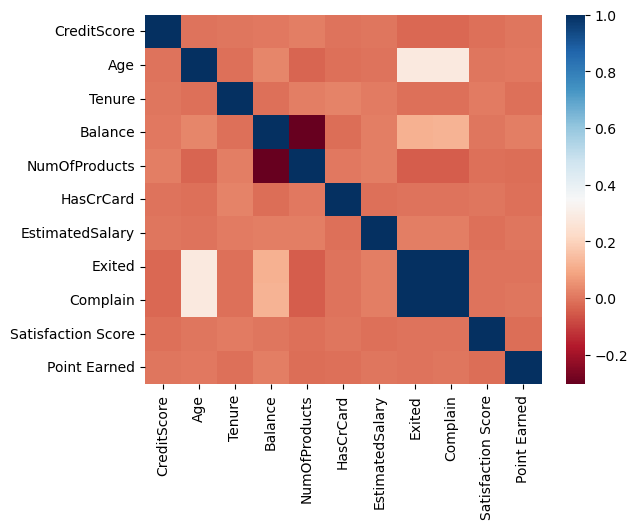

In [205]:
corr_data = df.corr(numeric_only=True)
print(corr_data)

corr = sns.heatmap(corr_data, cmap="RdBu", annot=False)

plt.show(corr)

In [206]:
df.corr(numeric_only=True)["Exited"].sort_values(ascending=False)

Exited                1.000000
Complain              0.995693
Age                   0.285296
Balance               0.118577
EstimatedSalary       0.012490
Point Earned         -0.004628
Satisfaction Score   -0.005849
HasCrCard            -0.006976
Tenure               -0.013656
CreditScore          -0.026771
NumOfProducts        -0.047611
Name: Exited, dtype: float64

### Feature 

In [207]:
X = df.drop(['Exited', 'Complain'], axis=1)
y = df['Exited']
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [208]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Gender              10000 non-null  object 
 2   Age                 10000 non-null  int64  
 3   Tenure              10000 non-null  int64  
 4   Balance             10000 non-null  float64
 5   NumOfProducts       10000 non-null  int64  
 6   HasCrCard           10000 non-null  int64  
 7   EstimatedSalary     10000 non-null  float64
 8   Satisfaction Score  10000 non-null  int64  
 9   Card Type           10000 non-null  object 
 10  Point Earned        10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [209]:
categorical_cols = ['Gender', 'Card Type']
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 
                  'Satisfaction Score', 'Point Earned']

In [210]:
X = df[numerical_cols + categorical_cols]
y = df["Exited"]

In [211]:
numerical_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encoding', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing_pipeline = ColumnTransformer([
  ('num', numerical_pipeline, numerical_cols),
  ('cat', categorical_pipeline, categorical_cols)
])

pipeline = Pipeline([
  ('preprocessor', preprocessing_pipeline),
  ('model', XGBClassifier(
      max_depth=5,
      learning_rate=0.05,
      n_estimators=300,
      subsample=0.8,
      colsample_bytree=0.8,
      min_child_weight=5
  ))
])

In [212]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size= 0.2, 
    stratify=y, 
    random_state=42
)

In [213]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'EstimatedSalary',
                                                   'Satisfaction Score',
                                                   'Point Earned']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encodi...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=300,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [214]:
Xt = pipeline.named_steps['preprocessor'].fit_transform(X_train)
print(type(Xt), Xt.shape)

<class 'numpy.ndarray'> (8000, 15)


In [215]:
prediction = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1].astype(int)
y_pred = (prediction >= 0.1).astype(int)

In [216]:
#metrics 
'''
1. ROC-AUC 
2. Recall - catch churn
3. PR-AUC
'''

cm = classification_report(y_test, y_pred)
print(cm)

y_prob_test = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob_test)
print("\nROC-AUC:", auc)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1592
           1       0.64      0.44      0.52       408

    accuracy                           0.84      2000
   macro avg       0.75      0.69      0.71      2000
weighted avg       0.82      0.84      0.82      2000


ROC-AUC: 0.8373500468026407


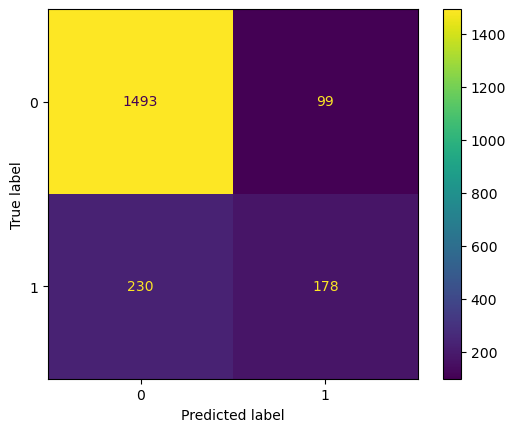

In [217]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [218]:
tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

Accuracy : 0.8355
Precision: 0.6425992779783394
Recall   : 0.4362745098039216
F1-score : 0.5197080291970804


In [219]:
df["churn_prob"] = pipeline.predict_proba(X)[:, 1]

In [220]:
# Rules 
q_low  = df["churn_prob"].quantile(0.4)
q_mid  = df["churn_prob"].quantile(0.6)
q_high = df["churn_prob"].quantile(0.95)

def assign_priority(row):
    if row["churn_prob"] >= q_high and row["Balance"] <= 50000:
        return "high_prio"
    elif row["churn_prob"] >= q_mid:
        return "moderate"
    elif row["churn_prob"] >= q_low:
        return "low_prio"
    else:
        return "neutral"

df["priority"] = df.apply(assign_priority, axis=1)

In [221]:
df.groupby("priority")["Exited"].mean()

priority
high_prio    0.964029
low_prio     0.064000
moderate     0.443149
neutral      0.016250
Name: Exited, dtype: float64

In [222]:
df.groupby("priority").agg(
    churn_rate=("Exited", "mean"),
    avg_prob=("churn_prob", "mean"),
    count=("Exited", "size")
)

,churn_rate,avg_prob,count
priority,,,
high_prio,0.964029,0.852573,139
low_prio,0.064000,0.108629,2000
moderate,0.443149,0.407046,3861
neutral,0.016250,0.035836,4000


In [223]:
df["priority"].value_counts(normalize=True)

neutral      0.4000
moderate     0.3861
low_prio     0.2000
high_prio    0.0139
Name: priority, dtype: float64

In [224]:
X2 = df[numerical_cols + categorical_cols]
y2 = df["priority"]

le = LabelEncoder()
y2_enc = le.fit_transform(y2)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2_enc,
    test_size=0.2,
    stratify=y2_enc,
    random_state=42
)

pipeline.fit(X2_train, y2_train)
pred = pipeline.predict(X2_test)

In [225]:
cm = confusion_matrix(y2_test, pred)
print(cm)

print(classification_report(
    y2_test,
    pred,
    target_names=le.classes_
))

[[ 17   0  11   0]
 [  0 234  70  96]
 [  3  83 680   6]
 [  0  72   3 725]]
              precision    recall  f1-score   support

   high_prio       0.85      0.61      0.71        28
    low_prio       0.60      0.58      0.59       400
    moderate       0.89      0.88      0.89       772
     neutral       0.88      0.91      0.89       800

    accuracy                           0.83      2000
   macro avg       0.80      0.74      0.77      2000
weighted avg       0.83      0.83      0.83      2000



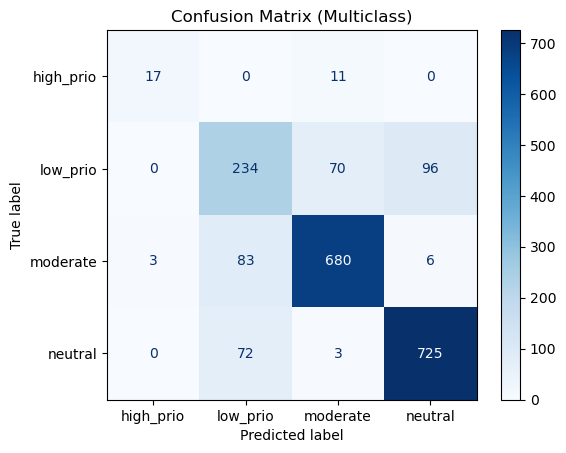

In [226]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Multiclass)")
plt.show()


In [227]:
le.classes_

array(['high_prio', 'low_prio', 'moderate', 'neutral'], dtype=object)

In [228]:
pd.DataFrame(
    pipeline.named_steps["model"].feature_importances_,
    index=pipeline.named_steps["preprocessor"].get_feature_names_out()
).sort_values(0, ascending=False).head(10)

,0
num__NumOfProducts,0.312449
num__Age,0.149583
num__Balance,0.086564
cat__Gender_Male,0.081521
cat__Gender_Female,0.081004
cat__Card Type_SILVER,0.041260
num__Satisfaction Score,0.034813
num__EstimatedSalary,0.031314
num__CreditScore,0.029669
cat__Card Type_GOLD,0.029268
